In [1]:
from tensorflow.python import keras
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas
from tensorflow.keras import utils
import cv2

/home/entilza/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/entilza/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/entilza/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/entilza/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
# Каталог с данными для обучения
trainDir = './dataset/train'
# Каталог с данными для проверки
valDir = './dataset/val'
# Каталог с данными для тестирования
testDir = './dataset/test'
# Размеры изображения
img_width, img_height = 100, 100
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Количество эпох обучения
epochs = 5
# Размер мини-выборки
batch_size = 28
# Количество изображений для обучения
nb_train_samples = 656
# Количество изображений для проверки
nb_validation_samples = 83
# Количество изображений для тестирования
nb_test_samples = 83

In [3]:
classes = ['круассан','полки','пончик', 'завиток',]

In [4]:
# include_top=False - параметр означает, что та часть, которая отвечает за классификацию не будет загружена
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
vgg16_net.trainable = False
vgg16_net.summary()
# Total params: 14,714,688 - число параметров, которые не обучаются

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________

In [5]:
model = Sequential()

#model.add(Conv2D(512, (3, 3), input_shape=input_shape))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(32, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(64, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(vgg16_net)

# т.к. на выходе из сети VGG16 двумерные карты признаков. 
#На входе в полносвязный слой должен подаваться плоский вектор
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# выходной полносвязный слой, который принимает значения из классов
model.add(Dense(4))
model.add(Activation('sigmoid'))

In [6]:
model.summary()
# Trainable params  - все обучаемые параметры находятся в полносвязных слоях, они же используются для классификации

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [8]:
# Добавляем трансформации изображения: 1. Фильтр "Соль и перец" 2. Изменение баланса белого 3. Размытие
def SaltAndPaper (im, probability):
    # probability of the noise 
    out = np.random.randint(0,probability, im.shape)
    out = out + im
    out[out>255]=255
    #out = out.astype(np.uint8)
    return out

def ColorBalance(im, probability):
    colorB = np.random.random() * (1-probability) + probability
    colorG = np.random.random() * (1-probability) + probability
    colorR = np.random.random() * (1-probability) + probability
    out = im.copy()
    out[:,:,0] = im[:,:, 0] * colorB
    out[:,:,1] = im[:,:, 1] * colorG
    out[:,:,2] = im[:,:, 2] * colorR
    return out

def BoxFilter(im, ksize):
    BoxFilter_image = cv2.boxFilter(im, 0, (ksize,ksize))
    return BoxFilter_image

def Transform(img):
    #img = ColorBalance(img, 0.5)
    #img = BoxFilter(img, 3)
    img = SaltAndPaper(img, 20)
    img = img.astype(np.float32)
    return img

In [9]:
# https://keras.io/preprocessing/image/
datagen = ImageDataGenerator(rescale=1./255., 
                             rotation_range=45,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             shear_range=0.2,
                             brightness_range=[0.5, 1.0],
                             channel_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode="nearest",
                             preprocessing_function=Transform
                            )

In [10]:
test_df = pandas.read_csv("./dataset/test.csv")
train_df = pandas.read_csv("./dataset/train.csv")
val_df = pandas.read_csv("./dataset/val.csv")

# https://keras.io/preprocessing/image/#flow_from_dataframe

train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col="filename",
        y_col="label",
        subset="training",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

val_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=None,
        x_col="filename",
        y_col="label",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=None,
        x_col="filename",
        y_col="label",
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='categorical')


Found 656 validated image filenames belonging to 4 classes.
Found 83 validated image filenames belonging to 4 classes.
Found 83 validated image filenames belonging to 4 classes.


In [17]:
# загрузка предварительно обученной модели, которая была уже обучена с помощью этого кода в несколько итераций
#model = keras.models.load_model('modelWork.hdf5')
# Reload the model from the 2 files we saved
with open('modelWork.json') as json_file:
    json_config = json_file.read()
model = keras.models.model_from_json(json_config)
model.load_weights('modelWork.h5')
#добавляем компиляцию, потому что она необходима для корректной работы после загрузки весов
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [12]:
model.summary()
#model.layers

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)


Epoch 1/5
23/23 [==============================] - 220s 10s/step - loss: 0.1675 - acc: 0.9459 - val_loss: 0.3040 - val_acc: 0.8571
Epoch 2/5
23/23 [==============================] - 226s 10s/step - loss: 0.0987 - acc: 0.9522 - val_loss: 0.1365 - val_acc: 0.9643
Epoch 3/5
23/23 [==============================] - 242s 11s/step - loss: 0.1003 - acc: 0.9612 - val_loss: 0.2663 - val_acc: 0.9107
Epoch 4/5
23/23 [==============================] - 228s 10s/step - loss: 0.0672 - acc: 0.9809 - val_loss: 0.2303 - val_acc: 0.9286
Epoch 5/5
23/23 [==============================] - 230s 10s/step - loss: 0.0515 - acc: 0.9804 - val_loss: 0.1670 - val_acc: 0.9464


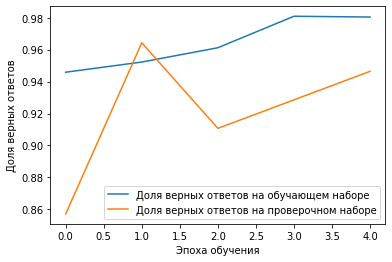

In [14]:
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [22]:
scores = model.evaluate_generator(test_generator, nb_test_samples)
print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

Точность на тестовых данных: 96.39%


In [16]:
# Задаем возможность обучения сети
# создаем флаг trainable, с помощью которого определяем, с какого блока будет обучаться сеть
# часть блоков сети VGG разблокируем для обучения нужных объектов
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block3_conv1':
        trainable = True
    layer.trainable = trainable

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Сохранение результатов обучения сети на каждой эпохе
# {epoch:02d} - номер эпохи
# {acc:.4f} - значение доли правильных значений на обучающем наборе данных с 4 знаками посе запятой
# {val_acc:.4f} - значение доли верных значений на проверочном наборе данных
callbacks = [ModelCheckpoint('SavedModel/{epoch:02d}-{acc:.4f}-{val_acc:.4f}.hdf5')]
# Сохраняем только тот вариант сети, который при обучении показал лучшее значение
#callbacks = [ModelCheckpoint('SavedModel/mnist-dense.hdf5', monitor='val_loss', save_best_only=True)]

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])

In [20]:
# т.к. количество изображений для каждого из классов не одинаково, вводим веса для каждого класса
class_weights_dict = {0:1 , 1:1, 2:1.26, 3:2.7}

In [21]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    class_weight = class_weights_dict,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size, 
    callbacks=callbacks
    )

Epoch 1/5
23/23 [==============================] - 284s 12s/step - loss: 0.1978 - acc: 0.9443 - val_loss: 0.3444 - val_acc: 0.8929
Epoch 2/5
23/23 [==============================] - 228s 10s/step - loss: 0.1176 - acc: 0.9697 - val_loss: 0.2400 - val_acc: 0.9643
Epoch 3/5
23/23 [==============================] - 222s 10s/step - loss: 0.1334 - acc: 0.9697 - val_loss: 0.4688 - val_acc: 0.8750
Epoch 4/5
23/23 [==============================] - 223s 10s/step - loss: 0.1136 - acc: 0.9777 - val_loss: 0.4016 - val_acc: 0.9107
Epoch 5/5
23/23 [==============================] - 230s 10s/step - loss: 0.1757 - acc: 0.9503 - val_loss: 0.1901 - val_acc: 0.9286


In [23]:
# Блок кода сохранения модели
#model.save('modelWork.hdf5')
# Сохраняем сеть
# Генерируем описание модели в формате json
model_json = model.to_json()
json_file = open("modelWork.json", "w")
# Сохраняем архитектуру сети
json_file.write(model_json)
json_file.close()
# Сохраняем данные о весах
model.save_weights("modelWork.h5")